### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

In [1]:
!pip install -q pymap3d
# !unzip -q /content/optical-edge-dev.zip
# !unzip -q sample-dataset-xss.zip


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import time
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization
from pose_est import mat2euler

In [4]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files')
import Utils
from Utils import jetson_timestamp_to_utc, closest_ea, closest_t, get_unix_timestamps, trans_vec_to_lla, EAE

In [27]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files/Utils.py'>

In [5]:
sample_dataset_dir = r"/home/datademon/Desktop/Data/cam"
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
print(sample_parent_dir)

['strip_E243_1679940124', 'strip_E246_1679940459', 'strip_E249_1679940782', 'strip_E249_1679940514', 'strip_E243_1679940528', 'strip_E246_1679940242', 'strip_E246_1679940565', 'strip_E249_1679940606', 'strip_E249_1679940429', 'strip_E243_1679940257', 'strip_E249_1679940691', 'strip_E249_1679940867', 'strip_E243_1679940395', 'strip_E246_1679940348', 'strip_E240_1679940412']


In [16]:
choice = 13
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])

Save-Path:  /home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E246/flight_parameters_estimation_strip_E246_1679940348.csv
No. of Samples:  279
['img_E246_701171440362_1679940348_545907683.tiff', 'img_E246_701504729820_1679940348_879347754.tiff']


In [17]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

unix_timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
unix_timestamps_list = list(map(get_unix_timestamps, timestamps_list))
print('Timestamps: ', unix_timestamps_list[:3], ', Timestamps-size: ', len(unix_timestamps_list))

# print()
# print('Time-Wise Path Storages -')
# print()
# pprint(flight_obj)


['2023-03-27 23:35:48.545908', '2023-03-27 23:35:48.879348', '2023-03-27 23:35:49.212076', '2023-03-27 23:35:49.545457', '2023-03-27 23:35:49.879053', '2023-03-27 23:35:50.212364', '2023-03-27 23:35:50.545656', '2023-03-27 23:35:50.878948', '2023-03-27 23:35:51.212258', '2023-03-27 23:35:51.545440', '2023-03-27 23:35:51.878264', '2023-03-27 23:35:52.211683', '2023-03-27 23:35:52.544890', '2023-03-27 23:35:52.878114', '2023-03-27 23:35:53.211506', '2023-03-27 23:35:53.544686', '2023-03-27 23:35:53.878038', '2023-03-27 23:35:54.211284', '2023-03-27 23:35:54.544564', '2023-03-27 23:35:54.877892', '2023-03-27 23:35:55.211280', '2023-03-27 23:35:55.544509', '2023-03-27 23:35:55.877747', '2023-03-27 23:35:56.210915', '2023-03-27 23:35:56.544273', '2023-03-27 23:35:56.877614', '2023-03-27 23:35:57.210861', '2023-03-27 23:35:57.544158', '2023-03-27 23:35:57.877398', '2023-03-27 23:35:58.210682', '2023-03-27 23:35:58.544011', '2023-03-27 23:35:58.877325', '2023-03-27 23:35:59.210606', '2023-03-

In [18]:
combine_ins_path_all = r"/home/datademon/Desktop/INS_Data/ins/combine_ins_E240_1679939655_time.csv"
combine_ins_path_time = r"/home/datademon/Desktop/INS_Data/ins/ins_E240_1679939655_time.csv"

dtypes = {' Jetson Time': np.float64}
df_ins_data_time = pd.read_csv(combine_ins_path_time, float_precision='high', dtype=dtypes)
df_ins_data_all = pd.read_csv(combine_ins_path_all)

# display(df_ins_data_time.head(3))
# display(df_ins_data_all.head(3))
df_ins_data_time[' Jetson Time'][0]

1679939655.8286555

In [19]:
j_col = df_ins_data_time.columns[-1]
p_col = df_ins_data_time.columns[0]

print('Columns of Interest: ', j_col, ', ', p_col)

Columns of Interest:   Jetson Time ,  Packet Count


In [20]:
ins_jetson = list(df_ins_data_time[j_col].dropna())
ins_jetson = [str(time).split('.')[0] + '_' + '0' for time in ins_jetson]
utc_ins_jetson = list(map(jetson_timestamp_to_utc, ins_jetson))
ins_flight_obj = {}
for unix_time, utc_time in zip(ins_jetson, utc_ins_jetson):
  ins_flight_obj[utc_time] = unix_time

In [21]:
num_frames = len(sample_dir)
print('No. of frames:', num_frames)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

No. of frames: 279


In [22]:
import numpy as np

sensor_width = 29.3  # mm
sensor_height = 29  # mm

image_width = 1920  # in pixels
image_height = 1200  # in pixels

pixel_size_x = sensor_width / image_width
pixel_size_y = sensor_height / image_height

scale_factor_x = pixel_size_x / fx  # m/pixel
scale_factor_y = pixel_size_y / fy  # m/pixel

scale_factor = (scale_factor_x + scale_factor_y) / 2

print('Scale-Factor: ', scale_factor)

Scale-Factor:  2.7423491862997134e-05


In [23]:
import time

initial_frame_timestamp = sample_dir[0]
print('initial_frame_timestamp: ', initial_frame_timestamp)

# ref_coordinates = [12.9, 80.2, 6.7]
df_data = [df_ins_data_time, df_ins_data_all]
ini_ea = closest_ea(initial_frame_timestamp, rev_flight_obj, df_data)
ini_coordinates = closest_t(initial_frame_timestamp, rev_flight_obj, df_data)

ini_frame_path = os.path.join(sample_dataset_path, sample_dir[0])
ini_frame = np.asarray(Image.open(ini_frame_path))

df_OF_cols = ['Timestamps', 'Roll_N', 'Pitch_E', 'Yaw_U', 'Latitude', 'Longitude', 'Altitude']
roll_list, pitch_list, yaw_list, lat_list, lon_list, alt_list = [], [], [], [], [], []

ft = time.time()

for i in tqdm(range(num_frames), desc="Processing frames", unit="frame"):

  roll_list.append(ini_ea[0])
  pitch_list.append(ini_ea[1])
  yaw_list.append(ini_ea[-1])
  lat_list.append(ini_coordinates[0])
  lon_list.append(ini_coordinates[1])
  alt_list.append(ini_coordinates[-1])

  if (i + 1) >= num_frames:
    break

  pass

  next_frame_path = os.path.join(sample_dataset_path, sample_dir[i + 1])
  next_frame = np.asarray(Image.open(next_frame_path))

  eae = EAE(ini_frame, next_frame, FeatureLocalization)
  one_frame_R, one_frame_t, euler_angle_rad, _ = eae.run(is_store = True)

  pred_ins_euler_angle = [(prev_ea + delta_ea) for delta_ea, prev_ea in zip(list(euler_angle_rad.values()), ini_ea)]
  lat, lon, alt = trans_vec_to_lla(one_frame_t, one_frame_R, scale_factor, ini_ea, ini_coordinates)

  ini_frame = next_frame
  ini_ea = pred_ins_euler_angle
  ini_coordinates = [lat, lon, alt]


df_of = pd.DataFrame(columns = df_OF_cols)

data = {
    'Timestamps': unix_timestamps_list,
    'Roll_N': roll_list,
    'Pitch_E': pitch_list,
    'Yaw_U': yaw_list,
    'Latitude': lat_list,
    'Longitude': lon_list,
    'Altitude': alt_list
}


df_of = pd.DataFrame(data)
display(df_of.head(3))

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

initial_frame_timestamp:  img_E246_701171440362_1679940348_545907683.tiff


Processing frames: 100%|█████████▉| 278/279 [02:27<00:00,  1.89frame/s]


,Timestamps,Roll_N,Pitch_E,Yaw_U,Latitude,Longitude,Altitude
0,1.679940e+09,1.520000,1.930000,10.480000,12.791219,80.189743,-43.610000
1,1.679940e+09,1.520019,1.930014,10.455241,12.791219,80.189743,-43.609994
2,1.679940e+09,1.520014,1.930007,10.457423,12.791219,80.189743,-43.610017


Execution-time (UNIX):  147.00661492347717


#### Plotting Pitch_E & Yaw_U

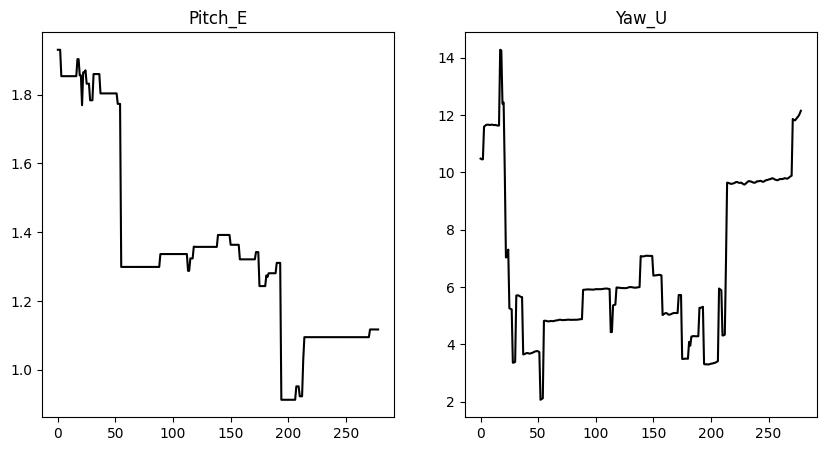

In [24]:
pitch_list = list(df_of.Pitch_E)
yaw_list = list(df_of.Yaw_U)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].plot(pitch_list, color = 'black')
axs[0].set_title('Pitch_E')

axs[1].plot(yaw_list, color = 'black')
axs[1].set_title('Yaw_U')

plt.show()

In [239]:
df_of.to_csv(save_file_name, index=False)

#### Some-Basic-Tests

In [20]:
rot_matrix = np.array([[9.999e-01, -9.570e-03, -6.588e-06], [9.5705e-03, 9.9995e01, -1.3386e-06], [6.6006e-06, 1.2754e-06, 1.000e+0]])
print(rot_matrix.shape)
euler_angles = mat2euler(rot_matrix, seq = 'xyz')
print((euler_angles[-1], euler_angles[-2], euler_angles[-3]))

rnd_img1, rnd_img2 = np.random.rand(512, 512, 3), np.random.rand(512, 512, 3)
print(rnd_img1.shape, rnd_img2.shape)
euler_angles_2 =  EAE(rnd_img1, rnd_img2, FeatureLocalization).calc_euler_angle(rot_matrix)
print(euler_angles_2)

(3, 3)
(1.2753999999993085e-06, -6.600599999898228e-06, 0.009571164872476117)
(512, 512, 3) (512, 512, 3)
(1.2753999999993085e-06, -6.600600000047929e-06, 0.009571164872476117)
